In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

In [4]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [130]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})

In [124]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-011/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})

In [82]:
print(len(visits))

78


In [131]:
dId = {'visit': visits[50], 'detector': 2}
raw = butler.get('raw', **dId)
bias = butler.get('bias', **dId)

In [132]:
detector = raw.getDetector()

In [8]:
afw_display.mtv(raw)

In [119]:
# for the geometry we've chosen, the y=0 amps are in the top
# Normally the read corner would tell you this, but there is currently a bug
flipXY = {'C00':(False, True),
          'C01':(False, True),
          'C02':(False, True),
          'C03':(False, True),
          'C04':(False, True),
          'C05':(False, True),
          'C06':(False, True),
          'C07':(False, True),
          'C10':(True, False),
          'C11':(True, False),
          'C12':(True, False),
          'C13':(True, False),
          'C14':(True, False),
          'C15':(True, False),
          'C16':(True, False),
          'C17':(True, False)}

In [32]:
overscans = {}
for key, value in flipXY.items():
    bbox = detector[key].getRawHorizontalOverscanBBox()
    overscans[key] = raw[bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image

In [33]:
overscans = {}
for key, value in list(flipXY.items())[0:8]:
    bbox = detector[key].getRawHorizontalOverscanBBox()
    data_bbox = detector[key].getRawDataBBox()
    print(key, bbox, data_bbox)

C00 (minimum=(522, 2094), maximum=(575, 4095)) (minimum=(10, 2094), maximum=(521, 4095))
C01 (minimum=(1098, 2094), maximum=(1151, 4095)) (minimum=(586, 2094), maximum=(1097, 4095))
C02 (minimum=(1674, 2094), maximum=(1727, 4095)) (minimum=(1162, 2094), maximum=(1673, 4095))
C03 (minimum=(2250, 2094), maximum=(2303, 4095)) (minimum=(1738, 2094), maximum=(2249, 4095))
C04 (minimum=(2826, 2094), maximum=(2879, 4095)) (minimum=(2314, 2094), maximum=(2825, 4095))
C05 (minimum=(3402, 2094), maximum=(3455, 4095)) (minimum=(2890, 2094), maximum=(3401, 4095))
C06 (minimum=(3978, 2094), maximum=(4031, 4095)) (minimum=(3466, 2094), maximum=(3977, 4095))
C07 (minimum=(4554, 2094), maximum=(4607, 4095)) (minimum=(4042, 2094), maximum=(4553, 4095))


In [133]:
from lsst.geom import Point2I, Extent2I, Box2I
new_overscans = {}
for key, value in list(flipXY.items())[0:8]:
    bbox = detector[key].getRawHorizontalOverscanBBox()
    new_point = Point2I(bbox.getMinX()-3, bbox.getMinY())
    new_extent = bbox.getDimensions()
    new_bbox = Box2I(new_point, new_extent)
    new_overscans[key] = raw[new_bbox].getMaskedImage().getImage().clone()



(2002, 54)
(2002, 54)
(2002, 54)
(2002, 54)
(2002, 54)
(2002, 54)


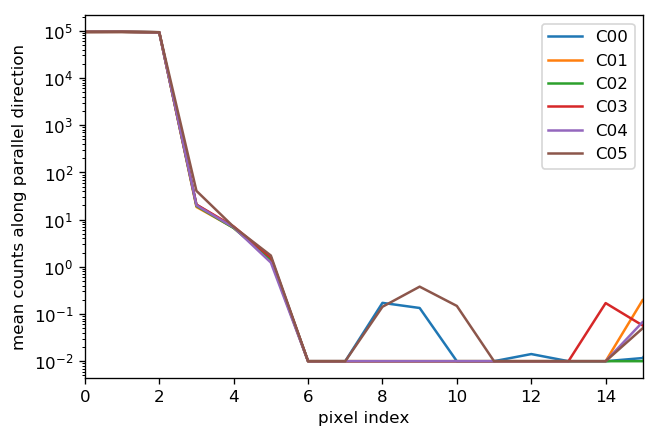

In [136]:
for channel_name, flips in list(flipXY.items())[0:6]:
    # get all the overscans in the same orientation and plot the mean along the y-axis
    arr = new_overscans[channel_name].getArray() # pull out numpy array
    oscan = numpy.mean(arr[:,30:-1],axis=1)
    oscan = oscan.reshape(2002,1)
    arr_oscan = arr-oscan
    print(arr_oscan.shape)
    fx, fy = flips
    if fx:
        arr = numpy.flip(arr, axis=1)
    if fy:
        arr = numpy.flip(arr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    oscan_mean = numpy.clip(numpy.mean(arr_oscan, axis=0),0.01,1.0E6)
    plt.plot(oscan_mean,label=channel_name)

plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.yscale('log')
plt.xlim(0, 15)
#plt.ylim(-0.5, 0.5)
plt.legend()

In [135]:
print(arr.shape)
print(oscan.shape)
print(oscan_mean.shape)
print(arr_oscan[500])


(2002, 54)
(2002, 1)
(54,)
[ 9.3097391e+04  9.4686391e+04  9.3350391e+04  2.3390625e+01
 -1.1609375e+01 -4.6093750e+00 -6.0937500e-01  3.9062500e-01
 -7.6093750e+00 -2.6093750e+00 -6.6093750e+00 -2.6093750e+00
  7.3906250e+00  2.3906250e+00  7.3906250e+00  9.3906250e+00
 -8.6093750e+00  1.1390625e+01  5.3906250e+00 -1.0609375e+01
 -1.6093750e+00 -1.3609375e+01  5.3906250e+00 -7.6093750e+00
 -6.0937500e-01  3.9062500e-01  7.3906250e+00 -8.6093750e+00
  7.3906250e+00  3.3906250e+00 -5.6093750e+00  2.3906250e+00
 -6.0937500e-01 -4.6093750e+00 -1.6093750e+00  1.1390625e+01
 -1.6093750e+00 -7.6093750e+00  2.3906250e+00  5.3906250e+00
 -6.6093750e+00 -4.6093750e+00 -6.0937500e-01  3.9062500e-01
  3.3906250e+00  3.3906250e+00 -3.6093750e+00  2.3906250e+00
 -6.6093750e+00 -8.6093750e+00  5.3906250e+00  5.3906250e+00
  1.0390625e+01  4.3906250e+00]
